In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mp
from pickle import Pickler
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap
import pykrige.ok 
from pykrige.ok import OrdinaryKriging
import scipy.interpolate
import math
from math import floor, log10
import matplotlib.animation as animation

import netCDF4 as nc
from salishsea_tools import  psu_tools
from seawater import eos80 

%matplotlib inline

In [2]:
### open bathymetry file and define the variables needed
etopo1 = nc.Dataset('/ocean/mgrenier/geotraces/research/ModelEval/BathyArctic/ETOPO1_Bed_g_gmt4.grd')
# Define numpy array 
lon_etopo = etopo1.variables['x'][:]
lat_etopo = etopo1.variables['y'][:]
bathy_etopo = etopo1.variables['z'][:]
llon, llat = np.meshgrid(lon_etopo, lat_etopo)

In [3]:
### Location of the WOD extraction files
directory = '/home/mgrenier/Documents/Data_Arctic/WorldOceanDatabase/18Oct16-64N90N-CTD/'


In [4]:
### Reading of the PaTh data file
import Data

data,sta,date,lon,lat,P,d,t,s,theta,Tpot,Tr,fluo,oxy_uM,oxy_mL,rho,isop,si,ti,NO3_1,NO3_2,PO3_1,PO3_2,SiO4_1,SiO4_2,nut = Data.AllData_variables()
PaThData,PaTh_sta,PaTh_lon,PaTh_lat,PaTh_t,PaTh_s,PaTh_theta,PaTh_rho,PaTh_d = Data.PaTh_variables()
listAllSta,listPaThSta,PaThDataSorted,PaThSort_sta,PaThSort_d,Pa,Th,PaTh,PaErr,ThErr,PaThErr = Data.PaTh_varSorted()

/home/mgrenier/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (0,10,11,28,30,31,32,33,34,35,36,37,38,39,41,42,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/ocean/mgrenier/geotraces/analysis-Melanie/notebooks/Geotraces2015data/Data.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data.Tpot[thetaOnly] = data.theta[thetaOnly]


453.0 13.0


/ocean/mgrenier/geotraces/analysis-Melanie/notebooks/Geotraces2015data/DerivVar.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  isop = np.zeros((ydim,xdim))
/home/mgrenier/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: DtypeWarning: Columns (0,10,11,28,30,31,32,33,34,35,36,37,38,39,41,42,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


453.0 13.0
453.0 13.0


/home/mgrenier/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: DtypeWarning: Columns (0,10,11,28,30,31,32,33,34,35,36,37,38,39,41,42,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.


453.0 13.0


In [5]:
### Listing the Pa/Th stations
ind = PaTh_lon.index.tolist()
listPaThLon = []
listPaThLat = []
listPaThSta = []
listPaThDate = []

for i in range(0,len(PaTh_lon),1):
#    if (PaTh_lon[ind[i]] not in listPaThLon):
    if ((PaTh_lon[ind[i]] not in listPaThLon) & (PaTh_lat[ind[i]] not in listPaThLat) 
        & (PaTh_sta[ind[i]] not in listPaThSta)):
        listPaThLon.append(PaTh_lon[ind[i]].tolist())
        listPaThLat.append(PaTh_lat[ind[i]].tolist())
        listPaThSta.append(PaTh_sta[ind[i]])
        listPaThDate.append(PaThData.date[ind[i]])


/home/mgrenier/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


KeyboardInterrupt: 

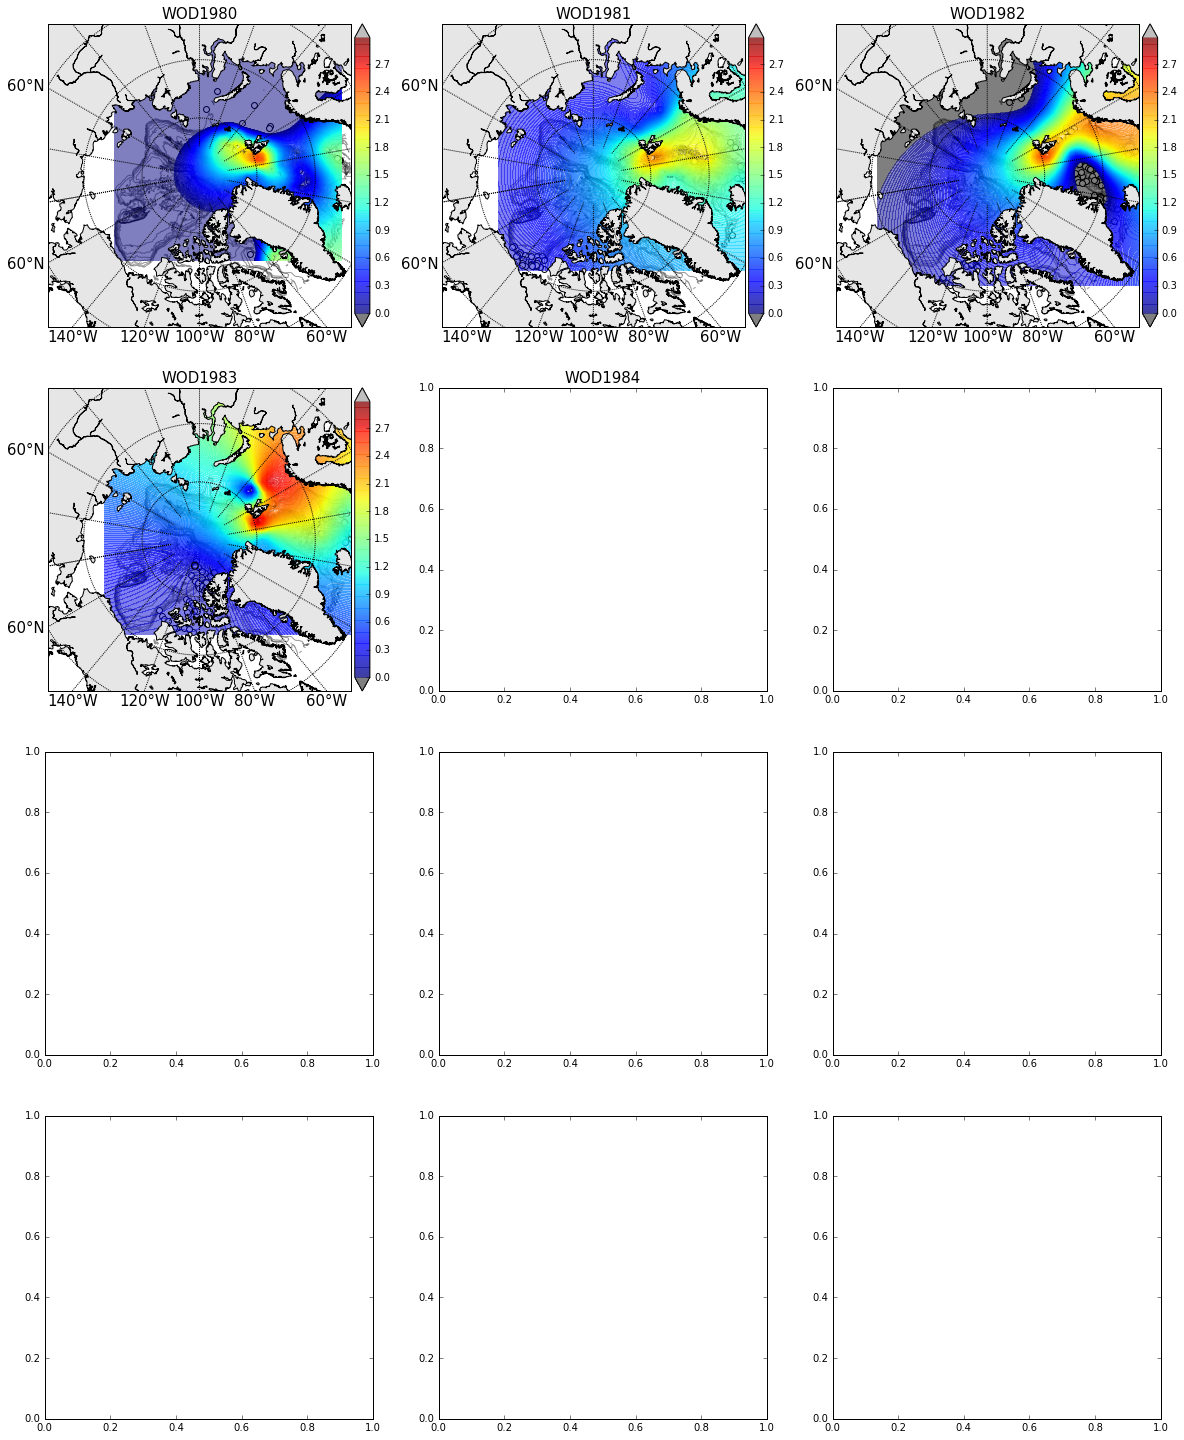

In [6]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12))=plt.subplots(4,3,facecolor='w',figsize=(20,25))
lev = np.arange(0, 3, 0.01)
for pickledFile,axs,year in zip(('WOD1980','WOD1981','WOD1982','WOD1983','WOD1984','WOD1985','WOD1986','WOD1987',
                                'WOD1988','WOD1989'),
                                (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10),
                                ('1980','1981','1982','1983','1984','1985','1986','1987','1988','1989')):
    axs.set_title(pickledFile, size = 15)
    var = pd.read_pickle(directory+pickledFile)
    find = data[data.date.str.startswith(year) == True]
    prep = find.iloc[:,[0,1,3,4,5,6,7,8,29,35,25,32]]
    prep.rename(columns={'date':'Date','lon':'Lon','lat':'Lat'}, inplace= True)
    var = pd.concat([var,prep])

    rho = var.rho
    t = var.temp
    
    lonlist = []
    ind = var.index.tolist()
    var_279 = pd.DataFrame()
    
    for i in range(0,len(var.Lon),1):
    #for i in range(0,30000,1):
        if var.Lon[ind[i]] not in lonlist:
            lonlist.append(var.Lon[ind[i]].tolist())
            var_lim=var[(rho > 27.895) & (rho < 27.905) & (var.Lon == lonlist[-1])]
        
            if (var_lim.rho.size == 1): 
                if(var_lim.rho.notnull().tolist()[0]):
                    var_279 = pd.concat([var_279,var_lim])
            if var_lim.rho.size > 1:
                find_closest = (var_lim.rho-27.9).abs().argsort()[:1]
                ind_closest = sum(find_closest.index.tolist(),find_closest.tolist())
                var_closest = var_lim[var_lim.index == ind_closest.tolist()]
                var_279 = pd.concat([var_279,var_closest])

    m = Basemap(projection='npstere',boundinglat=64,lon_0=-100,round=False,resolution='l',ax=axs)
    Lon_279,Lat_279 = m(var_279.Lon.tolist(),var_279.Lat.tolist())

    # create grids to interpolate (in meters, assume numpy as np)
    #res=40; xylim = [1.3e6, 5.7e6]
    xymin = min(min(Lon_279),min(Lat_279))
    xymax = max(max(Lon_279),max(Lat_279))

    magnitude_min = int(math.log10(xymin))
    round_down = int(xymin/float(pow(10,magnitude_min-1)))
    xyminlim = round_down*pow(10,magnitude_min-1)

    magnitude_max = int(math.log10(xymax))
    round_up = np.ceil(xymax/int(pow(10,magnitude_max-1)))
    xymaxlim = round_up*pow(10,magnitude_max-1)

    res=(xymaxlim - xyminlim) /1e5; xylim = [xyminlim, xymaxlim]
    listx_trans = np.linspace(xylim[0], xylim[1], res)
    listy_trans = np.linspace(xylim[0], xylim[1], res)
    gridx_trans, gridy_trans = np.meshgrid(listx_trans, listy_trans)

    # Build Kriging model
    K_obj = OrdinaryKriging(Lon_279, Lat_279, var_279.temp.tolist(),
    variogram_model='linear', verbose=False, enable_plotting=False)
    ## sample_var is the variable, same length as Lon_279
    ## variogram_model depends on your needs

    # Execute the Kriging model
    interpol_result, bias = K_obj.execute('grid', listx_trans, listy_trans)

    # Draw map and define bathymetry
    m.drawcoastlines()
    x_lon,y_lat = m(llon[9240:10801,:],llat[9240:10801,:])
    mp.rcParams['contour.negative_linestyle'] = 'solid'
    clevs = [-5000,-4500,-4000,-3500,-3000,-2500,-2000,-1500,-1000,-500]

    # Draw the kriging result + the position of the data
    sc=axs.scatter(Lon_279,Lat_279,c='w',marker='o',edgecolors='k',s=35,vmin=0,vmax=3)
    #CS = axs.pcolor(gridx_trans, gridy_trans, interpol_result,zorder = 1,alpha=0.5,vmin=0, vmax=3)
    CS = m.contourf(gridx_trans, gridy_trans, interpol_result,lev,alpha=0.5,vmin=0, vmax=3, extend='both',zorder = 1) 
    m.fillcontinents(color = '0.9',alpha=1,zorder = 1)
    m.drawparallels(np.arange(50.,90.,10.),labels=[1, 0, 0, 0],fontsize=15,zorder=1)
    m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1],latmax=85,fontsize=15,zorder=1)
    m.contour(x_lon,y_lat,bathy_etopo[9240:10801,:],clevs,linewidth=0.075,colors='black',alpha=0.4,zorder=-1)

    del var
    
    for i in range(0,len(listPaThDate)-1,1):
        if (listPaThDate[i].startswith(year) == True):
            mlon_Data,mlat_Data = m(listPaThLon[i],listPaThLat[i])
            axs.scatter(mlon_Data,mlat_Data,marker='o',facecolors='none',edgecolors='k',s=45,zorder=1)

    divider = make_axes_locatable(axs)
    caxX = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(CS, cax=caxX,extend='both')
    cbar.cmap.set_under('black')
    cbar.cmap.set_over('grey')

    extent = axs.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    name = "%s.png" % pickledFile
    fig.savefig(name, bbox_inches=extent.expanded(1.4, 1.2))

ax11.axis('off');
ax12.axis('off');


/home/mgrenier/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


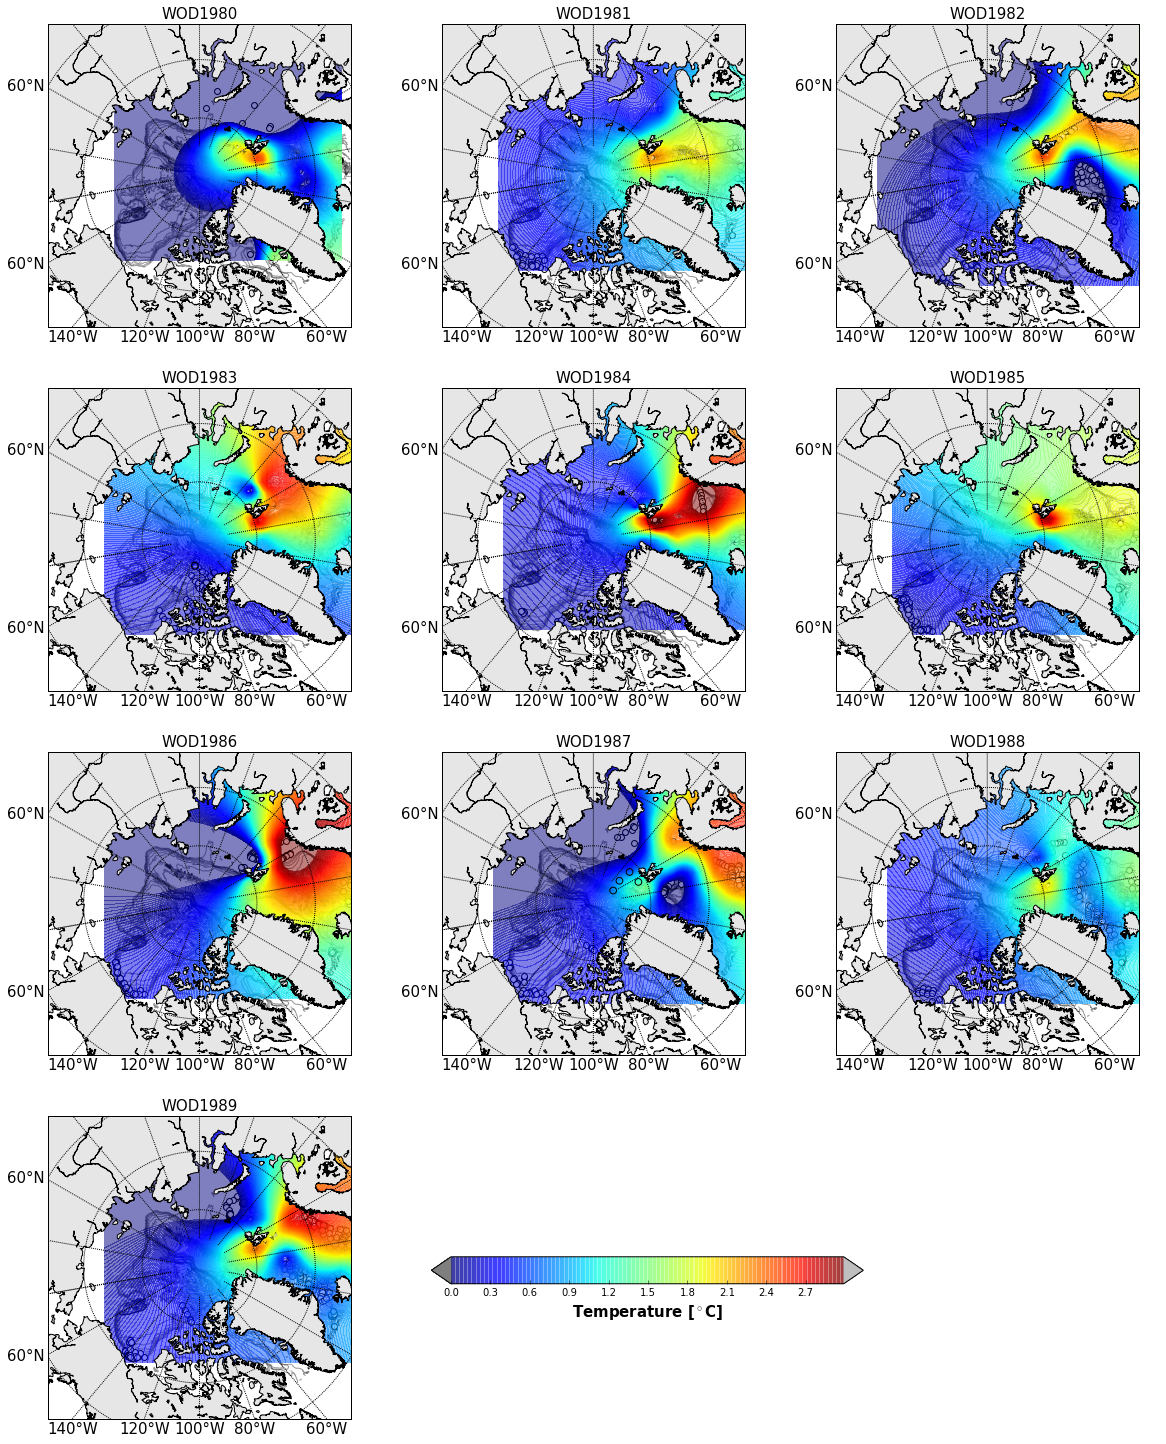

In [19]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12))=plt.subplots(4,3,facecolor='w',figsize=(20,25))
lev = np.arange(0, 3, 0.01)
for pickledFile,axs,year in zip(('WOD1980','WOD1981','WOD1982','WOD1983','WOD1984','WOD1985','WOD1986','WOD1987',
                                'WOD1988','WOD1989'),
                                (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10),
                                ('1980','1981','1982','1983','1984','1985','1986','1987','1988','1989')):
    axs.set_title(pickledFile, size = 15)
    var = pd.read_pickle(directory+pickledFile)
    find = data[data.date.str.startswith(year) == True]
    prep = find.iloc[:,[0,1,3,4,5,6,7,8,29,35,25,32]]
    prep.rename(columns={'date':'Date','lon':'Lon','lat':'Lat'}, inplace= True)
    var = pd.concat([var,prep])

    rho = var.rho
    t = var.temp
    
    lonlist = []
    ind = var.index.tolist()
    var_279 = pd.DataFrame()
    
    for i in range(0,len(var.Lon),1):
    #for i in range(0,30000,1):
        if var.Lon[ind[i]] not in lonlist:
            lonlist.append(var.Lon[ind[i]].tolist())
            var_lim=var[(rho > 27.895) & (rho < 27.905) & (var.Lon == lonlist[-1])]
        
            if (var_lim.rho.size == 1): 
                if(var_lim.rho.notnull().tolist()[0]):
                    var_279 = pd.concat([var_279,var_lim])
            if var_lim.rho.size > 1:
                find_closest = (var_lim.rho-27.9).abs().argsort()[:1]
                ind_closest = sum(find_closest.index.tolist(),find_closest.tolist())
                var_closest = var_lim[var_lim.index == ind_closest.tolist()]
                var_279 = pd.concat([var_279,var_closest])

    m = Basemap(projection='npstere',boundinglat=64,lon_0=-100,round=False,resolution='l',ax=axs)
    Lon_279,Lat_279 = m(var_279.Lon.tolist(),var_279.Lat.tolist())

    # create grids to interpolate (in meters, assume numpy as np)
    #res=40; xylim = [1.3e6, 5.7e6]
    xymin = min(min(Lon_279),min(Lat_279))
    xymax = max(max(Lon_279),max(Lat_279))

    magnitude_min = int(math.log10(xymin))
    round_down = int(xymin/float(pow(10,magnitude_min-1)))
    xyminlim = round_down*pow(10,magnitude_min-1)

    magnitude_max = int(math.log10(xymax))
    round_up = np.ceil(xymax/int(pow(10,magnitude_max-1)))
    xymaxlim = round_up*pow(10,magnitude_max-1)

    res=(xymaxlim - xyminlim) /1e5; xylim = [xyminlim, xymaxlim]
    listx_trans = np.linspace(xylim[0], xylim[1], res)
    listy_trans = np.linspace(xylim[0], xylim[1], res)
    gridx_trans, gridy_trans = np.meshgrid(listx_trans, listy_trans)

    # Build Kriging model
    K_obj = OrdinaryKriging(Lon_279, Lat_279, var_279.temp.tolist(),
    variogram_model='linear', verbose=False, enable_plotting=False)
    ## sample_var is the variable, same length as Lon_279
    ## variogram_model depends on your needs

    # Execute the Kriging model
    interpol_result, bias = K_obj.execute('grid', listx_trans, listy_trans)

    # Draw map and define bathymetry
    m.drawcoastlines()
    x_lon,y_lat = m(llon[9240:10801,:],llat[9240:10801,:])
    mp.rcParams['contour.negative_linestyle'] = 'solid'
    clevs = [-5000,-4500,-4000,-3500,-3000,-2500,-2000,-1500,-1000,-500]

    # Draw the kriging result + the position of the data
    sc=axs.scatter(Lon_279,Lat_279,c='w',marker='o',edgecolors='k',s=35,vmin=0,vmax=3)
    #CS = axs.pcolor(gridx_trans, gridy_trans, interpol_result,zorder = 1,alpha=0.5,vmin=0, vmax=3)
    CS = m.contourf(gridx_trans, gridy_trans, interpol_result,lev,alpha=0.5,vmin=0, vmax=3, extend='both',zorder = 1) 
    m.fillcontinents(color = '0.9',alpha=1,zorder = 1)
    m.drawparallels(np.arange(50.,90.,10.),labels=[1, 0, 0, 0],fontsize=15,zorder=1)
    m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1],latmax=85,fontsize=15,zorder=1)
    m.contour(x_lon,y_lat,bathy_etopo[9240:10801,:],clevs,linewidth=0.075,colors='black',alpha=0.4,zorder=-1)

    del var
    
    for i in range(0,len(listPaThDate)-1,1):
        if (listPaThDate[i].startswith(year) == True):
            mlon_Data,mlat_Data = m(listPaThLon[i],listPaThLat[i])
            axs.scatter(mlon_Data,mlat_Data,marker='o',facecolors='none',edgecolors='k',s=45,zorder=1)

ax11.axis('off');
ax12.axis('off');
cbar_ax = fig.add_axes([0.40, 0.2, 0.3, 0.015]) # Make an axis for the colorbar on the right side
CBar = plt.colorbar(CS,cax=cbar_ax,extend='both', label ='Temperature',orientation='horizontal') 
CBar.set_label(label='Temperature [$^\circ$C]',size=15,weight='bold')
CBar.ax.tick_params(labelsize=10)
CBar.cmap.set_under('black')
CBar.cmap.set_over('grey')

#cbar_ax = fig.add_axes([0.92, 0.1, 0.03, 0.8])
#fig.colorbar(sc, cax=cbar_ax)



/home/mgrenier/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


TypeError: 'PathCollection' object is not callable

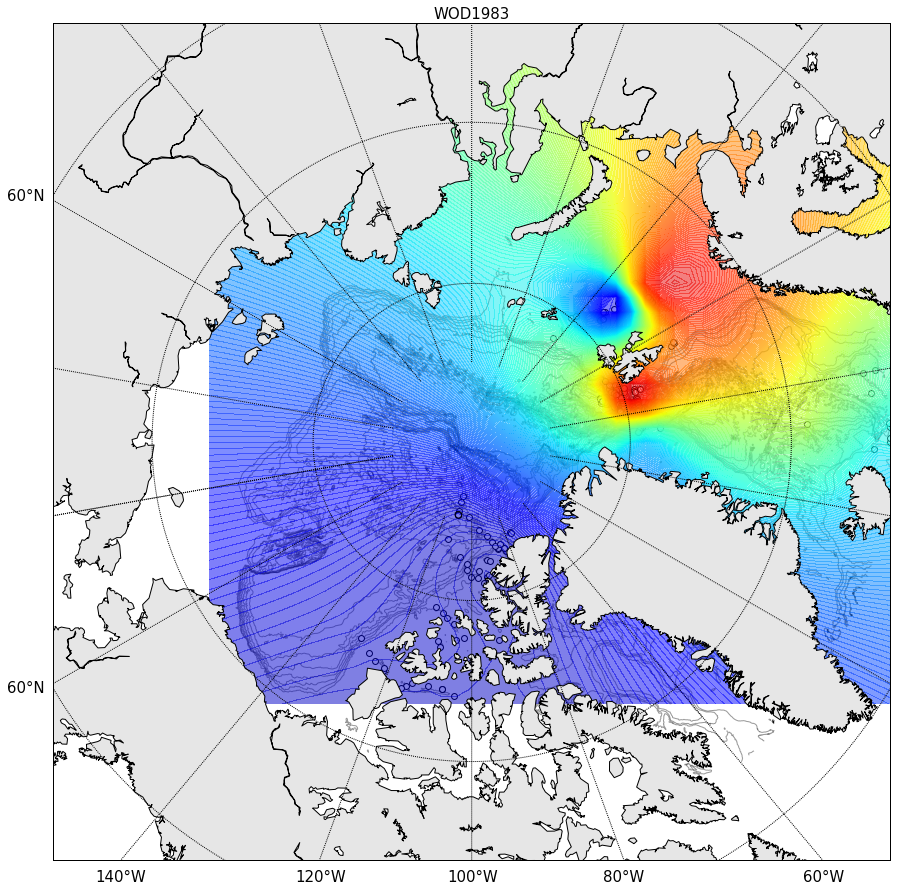

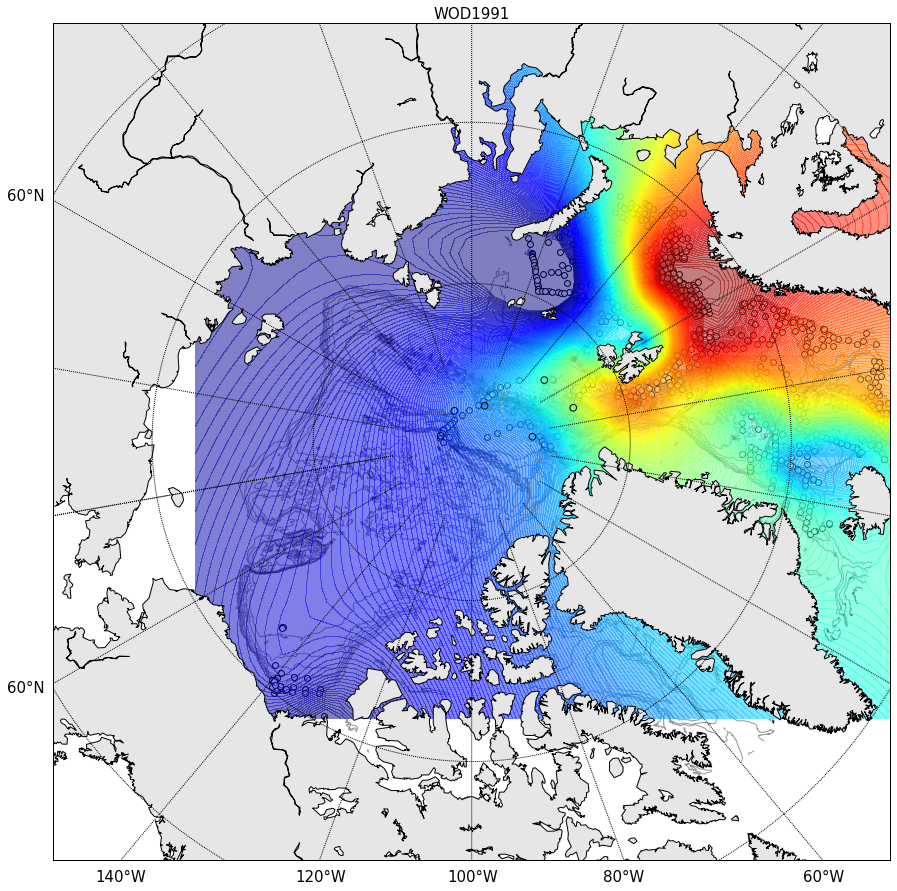

In [17]:
dpi = 100
lev = np.arange(0, 3, 0.01)
for pickledFile,year in zip(('WOD1983','WOD1991'),
                            ('1983','1991')):
    fig,axs=plt.subplots(1,1,facecolor='w',figsize=(15,15))
    axs.set_title(pickledFile, size = 15)
    var = pd.read_pickle(directory+pickledFile)
    find = data[data.date.str.startswith(year) == True]
    prep = find.iloc[:,[0,1,3,4,5,6,7,8,29,35,25,32]]
    prep.rename(columns={'date':'Date','lon':'Lon','lat':'Lat'}, inplace= True)
    var = pd.concat([var,prep])

    rho = var.rho
    t = var.temp
    
    lonlist = []
    ind = var.index.tolist()
    var_279 = pd.DataFrame()
    
    for i in range(0,len(var.Lon),1):
    #for i in range(0,30000,1):
        if var.Lon[ind[i]] not in lonlist:
            lonlist.append(var.Lon[ind[i]].tolist())
            var_lim=var[(rho > 27.895) & (rho < 27.905) & (var.Lon == lonlist[-1])]
        
            if (var_lim.rho.size == 1): 
                if(var_lim.rho.notnull().tolist()[0]):
                    var_279 = pd.concat([var_279,var_lim])
            if var_lim.rho.size > 1:
                find_closest = (var_lim.rho-27.9).abs().argsort()[:1]
                ind_closest = sum(find_closest.index.tolist(),find_closest.tolist())
                var_closest = var_lim[var_lim.index == ind_closest.tolist()]
                var_279 = pd.concat([var_279,var_closest])

    m = Basemap(projection='npstere',boundinglat=64,lon_0=-100,round=False,resolution='l',ax=axs)
    Lon_279,Lat_279 = m(var_279.Lon.tolist(),var_279.Lat.tolist())

    # create grids to interpolate (in meters, assume numpy as np)
    #res=40; xylim = [1.3e6, 5.7e6]
    xymin = min(min(Lon_279),min(Lat_279))
    xymax = max(max(Lon_279),max(Lat_279))

    magnitude_min = int(math.log10(xymin))
    round_down = int(xymin/float(pow(10,magnitude_min-1)))
    xyminlim = round_down*pow(10,magnitude_min-1)

    magnitude_max = int(math.log10(xymax))
    round_up = np.ceil(xymax/int(pow(10,magnitude_max-1)))
    xymaxlim = round_up*pow(10,magnitude_max-1)

    res=(xymaxlim - xyminlim) /1e5; xylim = [xyminlim, xymaxlim]
    listx_trans = np.linspace(xylim[0], xylim[1], res)
    listy_trans = np.linspace(xylim[0], xylim[1], res)
    gridx_trans, gridy_trans = np.meshgrid(listx_trans, listy_trans)

    # Build Kriging model
    K_obj = OrdinaryKriging(Lon_279, Lat_279, var_279.temp.tolist(),
    variogram_model='linear', verbose=False, enable_plotting=False)
    ## sample_var is the variable, same length as Lon_279
    ## variogram_model depends on your needs

    # Execute the Kriging model
    interpol_result, bias = K_obj.execute('grid', listx_trans, listy_trans)

    # Draw map and define bathymetry
    m.drawcoastlines()
    x_lon,y_lat = m(llon[9240:10801,:],llat[9240:10801,:])
    mp.rcParams['contour.negative_linestyle'] = 'solid'
    clevs = [-5000,-4500,-4000,-3500,-3000,-2500,-2000,-1500,-1000,-500]

    # Draw the kriging result + the position of the data
    sc=axs.scatter(Lon_279,Lat_279,c='w',marker='o',edgecolors='k',s=35,vmin=0,vmax=3)
    #CS = axs.pcolor(gridx_trans, gridy_trans, interpol_result,zorder = 1,alpha=0.5,vmin=0, vmax=3)
    CS = m.contourf(gridx_trans, gridy_trans, interpol_result,lev,alpha=0.5,vmin=0, vmax=3, extend='both',zorder = 1) 
    m.fillcontinents(color = '0.9',alpha=1,zorder = 1)
    m.drawparallels(np.arange(50.,90.,10.),labels=[1, 0, 0, 0],fontsize=15,zorder=1)
    m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1],latmax=85,fontsize=15,zorder=1)
    m.contour(x_lon,y_lat,bathy_etopo[9240:10801,:],clevs,linewidth=0.075,colors='black',alpha=0.4,zorder=-1)
    
    del var
    
    for i in range(0,len(listPaThDate)-1,1):
        if (listPaThDate[i].startswith(year) == True):
            mlon_Data,mlat_Data = m(listPaThLon[i],listPaThLat[i])
            test=axs.scatter(mlon_Data,mlat_Data,marker='o',facecolors='none',edgecolors='k',s=45,zorder=1)

ani = animation.FuncAnimation(fig,test,interval=30,blit=True,repeat_delay=0)
writer = animation.writers['ffmpeg'](fps=30)
    

ani.save('demo.mp4',writer=writer,dpi=dpi)
ax11.axis('off');
ax12.axis('off');
cbar_ax = fig.add_axes([0.40, 0.2, 0.3, 0.015]) # Make an axis for the colorbar on the right side
CBar = plt.colorbar(CS,cax=cbar_ax,extend='both', label ='Temperature',orientation='horizontal') 
CBar.set_label(label='Temperature [$^\circ$C]',size=15,weight='bold')
CBar.ax.tick_params(labelsize=10)
CBar.cmap.set_under('black')
CBar.cmap.set_over('grey')

#cbar_ax = fig.add_axes([0.92, 0.1, 0.03, 0.8])
#fig.colorbar(sc, cax=cbar_ax)


In [15]:
#data[data.date.startswith('2015')]
var = pd.read_pickle(directory+'WOD1983')
find = data[data.date.str.startswith('1983') == True]
prep = find.iloc[:,[0,1,3,4,5,6,7,8,29,35,25,32]]
prep.rename(columns={'date':'Date','lon':'Lon','lat':'Lat'}, inplace= True)
var = pd.concat([var,prep])
#var.head(10)
var
plt.show(fig)

/home/mgrenier/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [74]:
prep.head(10)
pd.concat([var,prep])

Cruise              Date     Lat       Lon        P   Station  \
1098747  WOD13_CA  1983-03-21T00:49  74.825 -96.71701     2.83   9296796   
1098748  WOD13_CA  1983-03-21T00:49  74.825 -96.71701     4.04   9296796   
1098749  WOD13_CA  1983-03-21T00:49  74.825 -96.71701     6.06   9296796   
1098750  WOD13_CA  1983-03-21T00:49  74.825 -96.71701     8.08   9296796   
1098751  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    10.11   9296796   
1098752  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    12.23   9296796   
1098753  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    14.15   9296796   
1098754  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    16.27   9296796   
1098755  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    18.19   9296796   
1098756  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    20.31   9296796   
1098757  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    22.43   9296796   
1098758  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    24.25   9296796   
1098759  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    26.27   9296796   
1098760  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    28.30   9296796   
1098761  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    30.32   9296796   
1098762  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    32.34   9296796   
1098763  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    34.36   9296796   
1098764  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    36.38   9296796   
1098765  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    38.50   9296796   
1098766  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    40.52   9296796   
1098767  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    42.55   9296796   
1098768  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    44.57   9296796   
1098769  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    46.69   9296796   
1098770  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    48.61   9296796   
1098771  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    50.63   9296796   
1098772  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    52.55   9296796   
1098773  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    54.78   9296796   
1098774  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    56.80   9296796   
1098775  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    58.72   9296796   
1098776  WOD13_CA  1983-03-21T00:49  74.825 -96.71701    60.74   9296796   
...           ...               ...     ...       ...      ...       ...   
139617      CESAR               NaN     NaN       NaN  1487.50  CTD-4915   
139618      CESAR               NaN     NaN       NaN  1488.00  CTD-4915   
139619      CESAR               NaN     NaN       NaN  1488.50  CTD-4915   
139620      CESAR               NaN     NaN       NaN  1489.00  CTD-4915   
139621      CESAR               NaN     NaN       NaN  1489.50  CTD-4915   
139622      CESAR               NaN     NaN       NaN  1490.00  CTD-4915   
139623      CESAR               NaN     NaN       NaN  1490.50  CTD-4915   
139624      CESAR               NaN     NaN       NaN  1491.00  CTD-4915   
139625      CESAR               NaN     NaN       NaN  1491.50  CTD-4915   
139626      CESAR               NaN     NaN       NaN  1492.00  CTD-4915   
139627      CESAR               NaN     NaN       NaN  1492.50  CTD-4915   
139628      CESAR               NaN     NaN       NaN  1493.00  CTD-4915   
139629      CESAR               NaN     NaN       NaN  1493.50  CTD-4915   
139630      CESAR               NaN     NaN       NaN  1494.00  CTD-4915   
139631      CESAR               NaN     NaN       NaN  1494.50  CTD-4915   
139632      CESAR               NaN     NaN       NaN  1495.00  CTD-4915   
139633      CESAR               NaN     NaN       NaN  1495.50  CTD-4915   
139634      CESAR               NaN     NaN       NaN  1496.00  CTD-4915   
139635      CESAR               NaN     NaN       NaN  1496.50  CTD-4915   
139636      CESAR               NaN     NaN       NaN  1497.00  CTD-4915   
139637      CESAR               NaN     NaN       NaN  1497

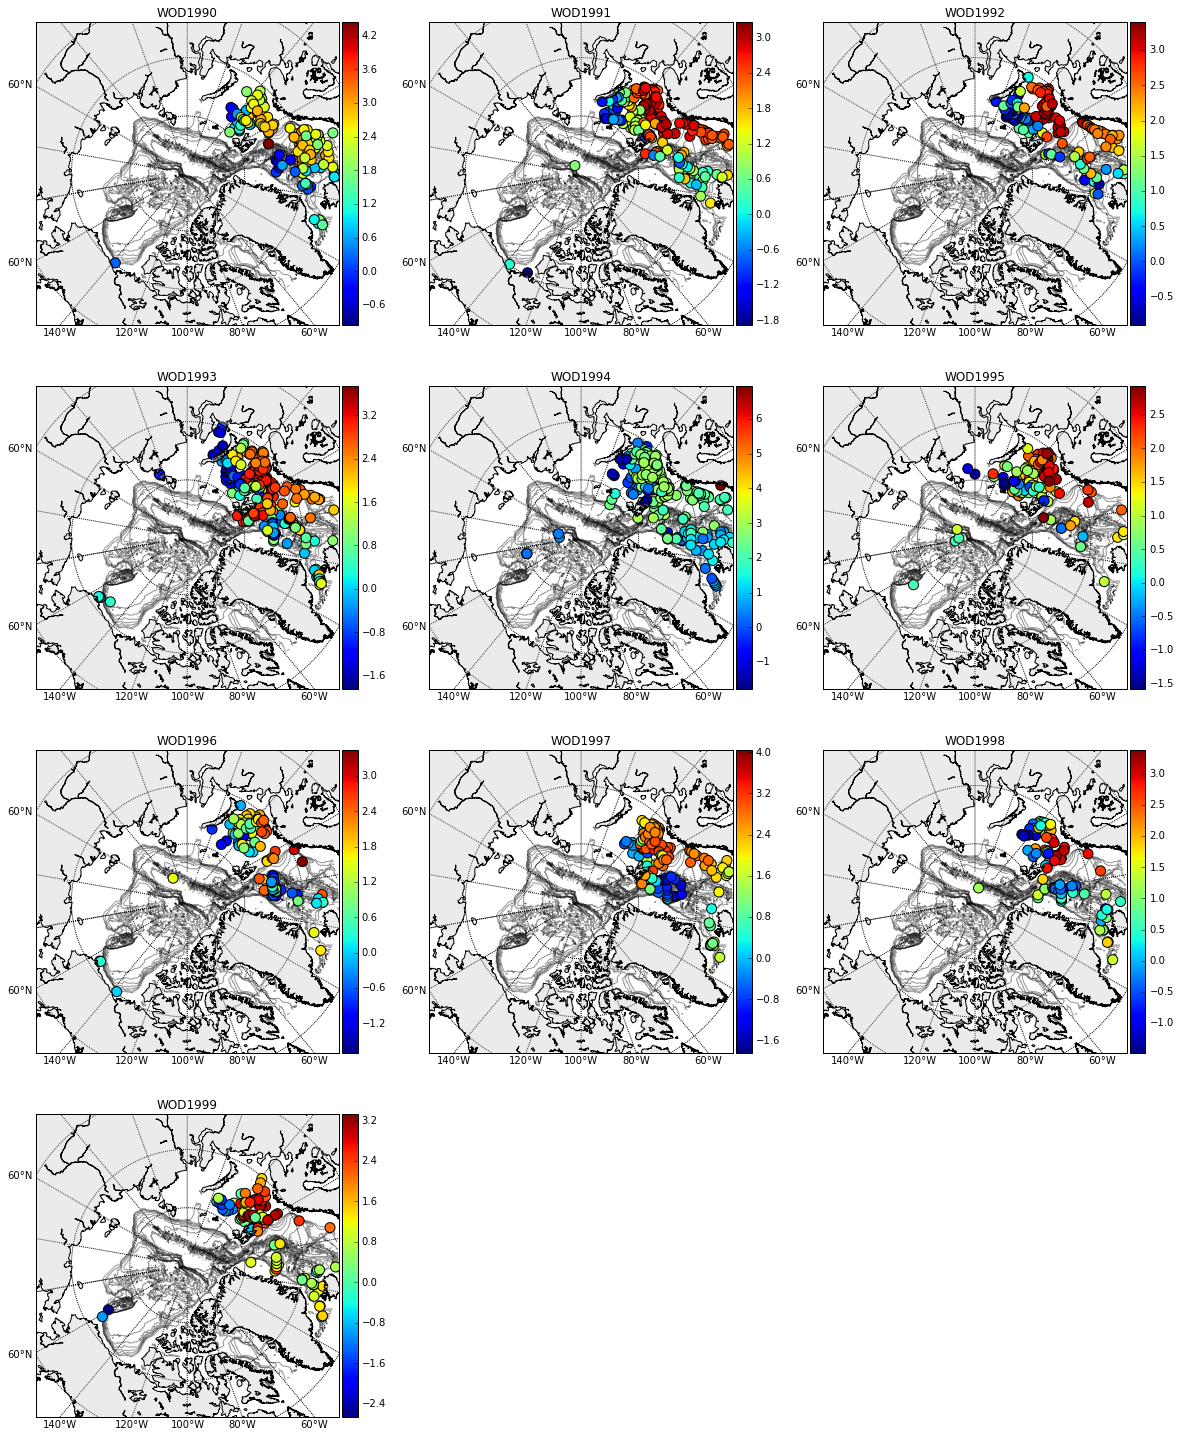

In [6]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12))=plt.subplots(4,3,facecolor='w',figsize=(20,25))

for var,pickledFile,axs in zip((WOD1990,WOD1991,WOD1992,WOD1993,WOD1994,WOD1995,WOD1996,WOD1997,WOD1998,WOD1999),
                               ('WOD1990','WOD1991','WOD1992','WOD1993','WOD1994','WOD1995','WOD1996','WOD1997',
                                'WOD1998','WOD1999'),
                               (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10)):
    axs.set_title(pickledFile)
    var = pd.read_pickle(directory+pickledFile)
    rho = var.rho
    t = var.temp
    
    lonlist = []
    ind = var.index.tolist()
    var_279 = pd.DataFrame()
    
    for i in range(0,len(var.Lon),1):
    #for i in range(0,30000,1):
        if var.Lon[ind[i]] not in lonlist:
            lonlist.append(var.Lon[ind[i]].tolist())
            var_lim=var[(rho > 27.895) & (rho < 27.905) & (var.Lon == lonlist[-1])]
        
            if (var_lim.rho.size == 1): 
                if(var_lim.rho.notnull().tolist()[0]):
                    var_279 = pd.concat([var_279,var_lim])
            if var_lim.rho.size > 1:
                find_closest = (var_lim.rho-27.9).abs().argsort()[:1]
                ind_closest = sum(find_closest.index.tolist(),find_closest.tolist())
                var_closest = var_lim[var_lim.index == ind_closest.tolist()]
                var_279 = pd.concat([var_279,var_closest])
 

    var_279 = var_279[var_279.Cruise.notnull()]
    var_279
    
    ## Plot the temperature surface with basemap 
    
    m = Basemap(projection='npstere',boundinglat=64,lon_0=-100,resolution='l',ax=axs)
    m.drawcoastlines()
    m.fillcontinents(color = '0.75',alpha=0.3)
    m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0],zorder=-1)
    m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1],latmax=85,zorder=-1)


    x_lon,y_lat = m(llon[9240:10801,:],llat[9240:10801,:])
    mp.rcParams['contour.negative_linestyle'] = 'solid'
    clevs = [-5000,-4500,-4000,-3500,-3000,-2500,-2000,-1500,-1000,-500]

    #plt.plot(x_lon[::20,::20],y_lat[::20,::20],x_lon[::20,::20].T,y_lat[::20,::20].T,color='k',lw=0.1)
    Lon_279,Lat_279 = m(var_279.Lon.tolist(),var_279.Lat.tolist())
    m.contour(x_lon,y_lat,bathy_etopo[9240:10801,:],clevs,linewidth=0.075,colors='black',alpha=0.4,zorder=-1)
    sc=axs.scatter(Lon_279,Lat_279,c=var_279.temp.tolist(),s=100)#,vmin=-1.8,vmax=3)
    divider = make_axes_locatable(axs)
    caxX = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(sc, cax=caxX)

    del var

ax11.axis('off');
ax12.axis('off');

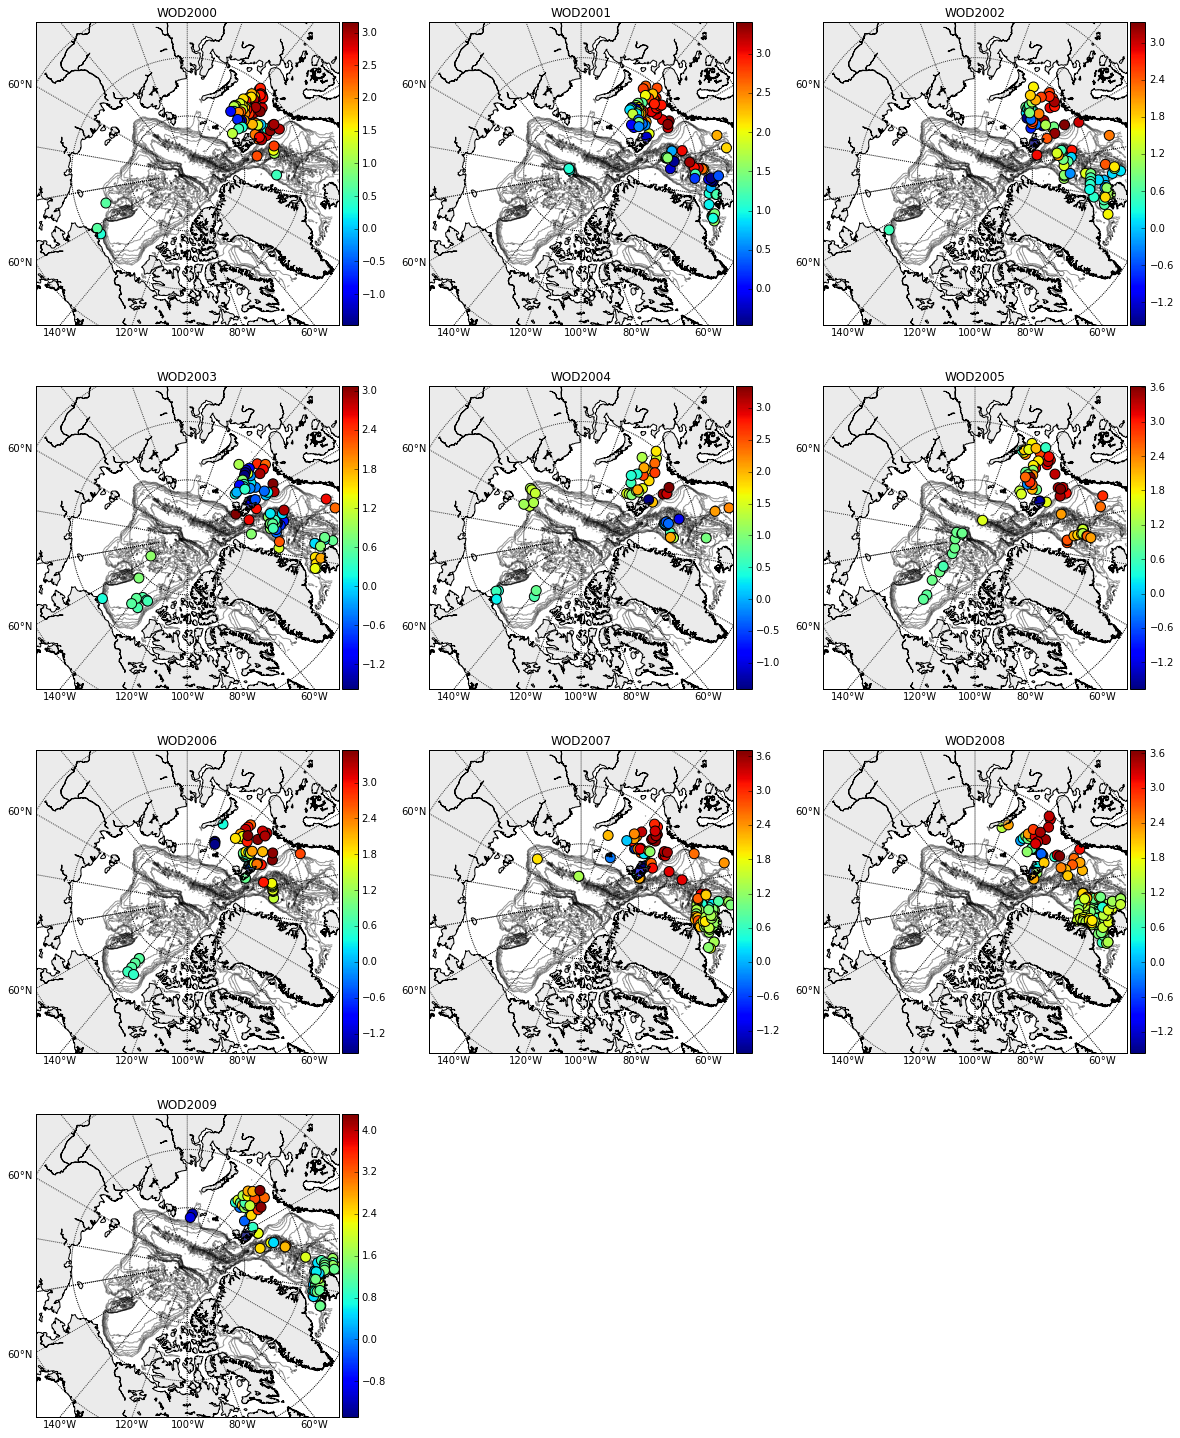

In [24]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12))=plt.subplots(4,3,facecolor='w',figsize=(20,25))

for var,pickledFile,axs in zip((WOD2000,WOD2001,WOD2002,WOD2003,WOD2004,WOD2005,WOD2006,WOD2007,WOD2008,WOD2009),
                               ('WOD2000','WOD2001','WOD2002','WOD2003','WOD2004','WOD2005','WOD2006','WOD2007',
                                'WOD2008','WOD2009'),
                               (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10)):
    axs.set_title(pickledFile)
    var = pd.read_pickle(directory+pickledFile)
    rho = var.rho
    t = var.temp
    
    lonlist = []
    ind = var.index.tolist()
    var_279 = pd.DataFrame()
    
    for i in range(0,len(var.Lon),1):
    #for i in range(0,30000,1):
        if var.Lon[ind[i]] not in lonlist:
            lonlist.append(var.Lon[ind[i]].tolist())
            var_lim=var[(rho > 27.895) & (rho < 27.905) & (var.Lon == lonlist[-1])]
        
            if (var_lim.rho.size == 1): 
                if(var_lim.rho.notnull().tolist()[0]):
                    var_279 = pd.concat([var_279,var_lim])
            if var_lim.rho.size > 1:
                find_closest = (var_lim.rho-27.9).abs().argsort()[:1]
                ind_closest = sum(find_closest.index.tolist(),find_closest.tolist())
                var_closest = var_lim[var_lim.index == ind_closest.tolist()]
                var_279 = pd.concat([var_279,var_closest])
 

    var_279 = var_279[var_279.Cruise.notnull()]
    var_279
    
    ## Plot the temperature surface with basemap 
    
    m = Basemap(projection='npstere',boundinglat=64,lon_0=-100,resolution='l',ax=axs)
    m.drawcoastlines()
    m.fillcontinents(color = '0.75',alpha=0.3)
    m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0],zorder=-1)
    m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1],latmax=85,zorder=-1)


    x_lon,y_lat = m(llon[9240:10801,:],llat[9240:10801,:])
    mp.rcParams['contour.negative_linestyle'] = 'solid'
    clevs = [-5000,-4500,-4000,-3500,-3000,-2500,-2000,-1500,-1000,-500]

    #plt.plot(x_lon[::20,::20],y_lat[::20,::20],x_lon[::20,::20].T,y_lat[::20,::20].T,color='k',lw=0.1)
    Lon_279,Lat_279 = m(var_279.Lon.tolist(),var_279.Lat.tolist())
    m.contour(x_lon,y_lat,bathy_etopo[9240:10801,:],clevs,linewidth=0.075,colors='black',alpha=0.4,zorder=-1)
    sc=axs.scatter(Lon_279,Lat_279,c=var_279.temp.tolist(),s=100)#,vmin=-1.8,vmax=3)
    divider = make_axes_locatable(axs)
    caxX = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(sc, cax=caxX)

    del var

ax11.axis('off');
ax12.axis('off');

AttributeError: 'DataFrame' object has no attribute 'Cruise'

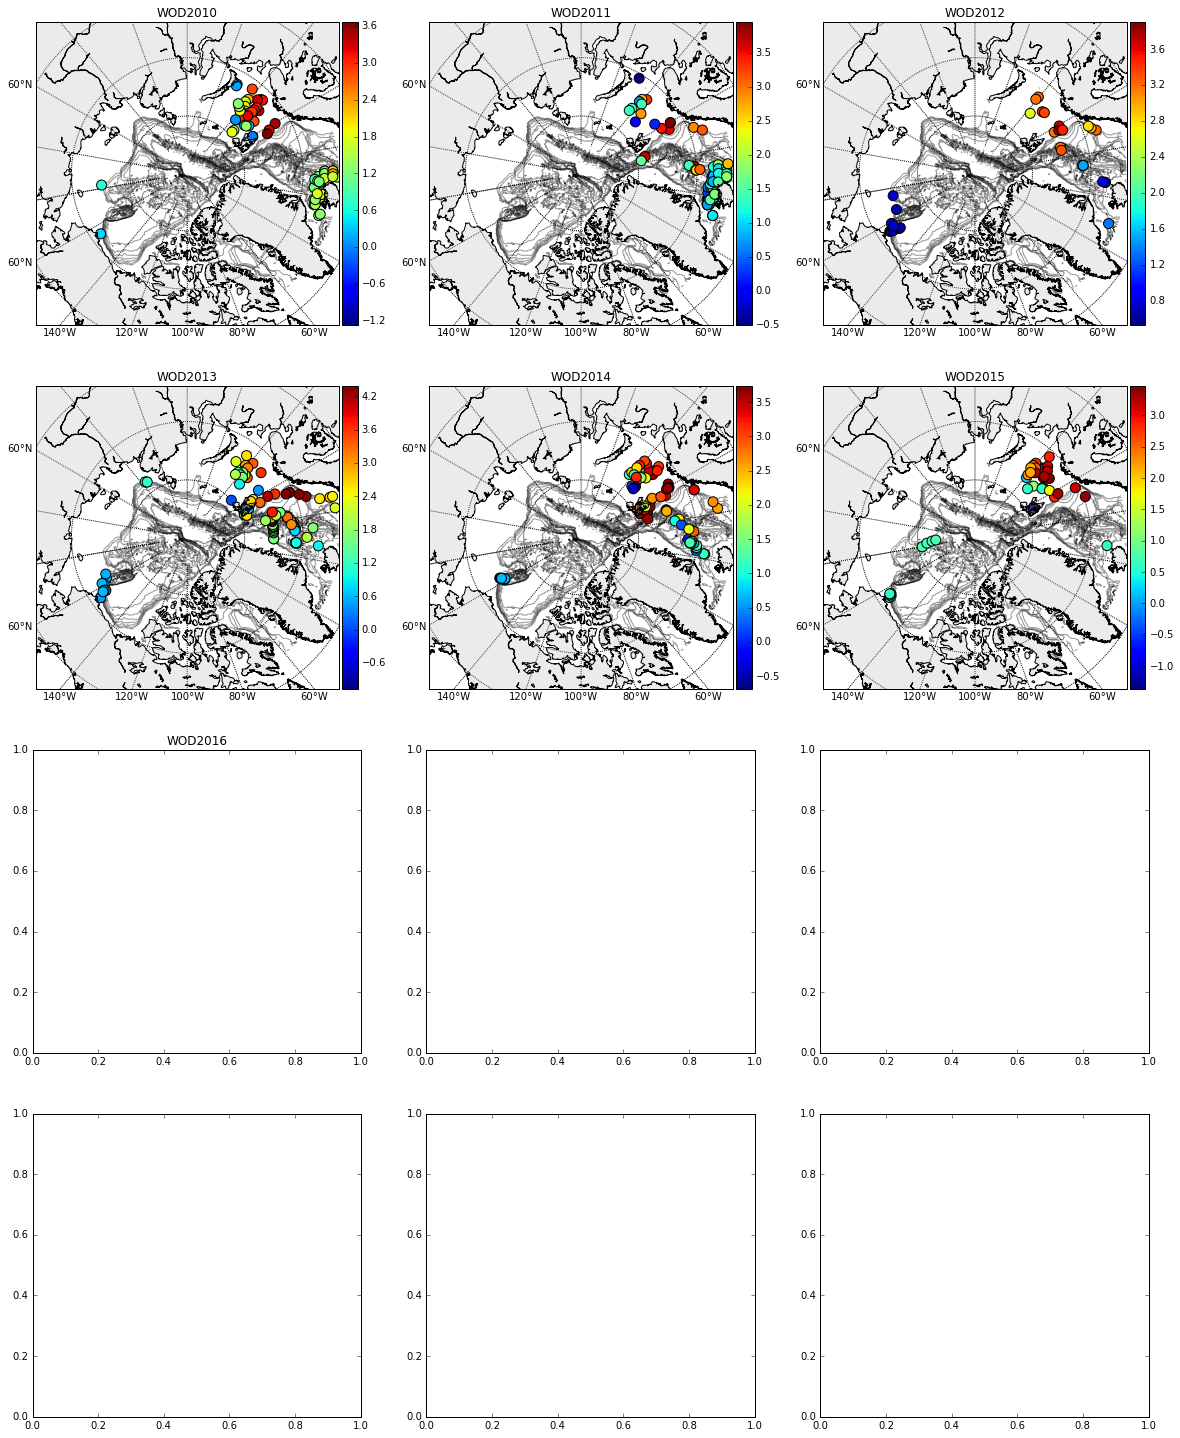

In [8]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12))=plt.subplots(4,3,facecolor='w',figsize=(20,25))

for var,pickledFile,axs in zip((WOD2010,WOD2011,WOD2012,WOD2013,WOD2014,WOD2015,WOD2016),
                               ('WOD2010','WOD2011','WOD2012','WOD2013','WOD2014','WOD2015','WOD2016'),
                               (ax1,ax2,ax3,ax4,ax5,ax6,ax7)):
    axs.set_title(pickledFile)
    var = pd.read_pickle(directory+pickledFile)
    rho = var.rho
    t = var.temp
    
    lonlist = []
    ind = var.index.tolist()
    var_279 = pd.DataFrame()
    
    for i in range(0,len(var.Lon),1):
    #for i in range(0,30000,1):
        if var.Lon[ind[i]] not in lonlist:
            lonlist.append(var.Lon[ind[i]].tolist())
            var_lim=var[(rho > 27.895) & (rho < 27.905) & (var.Lon == lonlist[-1])]
        
            if (var_lim.rho.size == 1): 
                if(var_lim.rho.notnull().tolist()[0]):
                    var_279 = pd.concat([var_279,var_lim])
            if var_lim.rho.size > 1:
                find_closest = (var_lim.rho-27.9).abs().argsort()[:1]
                ind_closest = sum(find_closest.index.tolist(),find_closest.tolist())
                var_closest = var_lim[var_lim.index == ind_closest.tolist()]
                var_279 = pd.concat([var_279,var_closest])
 

    var_279 = var_279[var_279.Cruise.notnull()]
    var_279
    
    ## Plot the temperature surface with basemap 
    
    m = Basemap(projection='npstere',boundinglat=64,lon_0=-100,resolution='l',ax=axs)
    m.drawcoastlines()
    m.fillcontinents(color = '0.75',alpha=0.3)
    m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0],zorder=-1)
    m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1],latmax=85,zorder=-1)


    x_lon,y_lat = m(llon[9240:10801,:],llat[9240:10801,:])
    mp.rcParams['contour.negative_linestyle'] = 'solid'
    clevs = [-5000,-4500,-4000,-3500,-3000,-2500,-2000,-1500,-1000,-500]

    #plt.plot(x_lon[::20,::20],y_lat[::20,::20],x_lon[::20,::20].T,y_lat[::20,::20].T,color='k',lw=0.1)
    Lon_279,Lat_279 = m(var_279.Lon.tolist(),var_279.Lat.tolist())
    m.contour(x_lon,y_lat,bathy_etopo[9240:10801,:],clevs,linewidth=0.075,colors='black',alpha=0.4,zorder=-1)
    sc=axs.scatter(Lon_279,Lat_279,c=var_279.temp.tolist(),s=100)#,vmin=-1.8,vmax=3)
    divider = make_axes_locatable(axs)
    caxX = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(sc, cax=caxX)

    del var
for ax in (ax8,ax9,ax10,ax11,ax12):
    ax.axis('off');


In [40]:
# As a summarize, you need to have "pykrige", "Basemap", "numpy" and "scipy";
# Have sample lon, lat, records ready as 1-d arrays without NaNs;
# Then do the following:
# ------------------------------------------------------------------------ #
# create Basemap object
m=Basemap(projection='npstere',boundinglat=64,lon_0=-100,resolution='l')#,ax=axs)

# transfer sample lats/lons
Lon_279,Lat_279 = m(var_279.Lon.tolist(),var_279.Lat.tolist())

# create grids to interpolate (in meters, assume numpy as np)
res=40; xylim = [1e7, 1.7e7]
res=40; xylim = [0, 1e7]
res=40; xylim = [1.3e6, 5.7e6]
listx_trans = np.linspace(xylim[0], xylim[1], res)
listy_trans = np.linspace(xylim[0], xylim[1], res)
gridx_trans, gridy_trans = np.meshgrid(listx_trans, listy_trans)

# Build Kriging model
from pykrige.ok import OrdinaryKriging
K_obj = OrdinaryKriging(Lon_279, Lat_279, var_279.temp.tolist(),
variogram_model='linear', verbose=False, enable_plotting=False)
## sample_var is the variable, same length as Lon_279
## variogram_model depends on your needs

# Execute the Kriging model
interpol_result, bias = K_obj.execute('grid', listx_trans, listy_trans)
# Transfer the grid in meters back to lats/lons
gridx, gridy = m(gridx_trans, gridy_trans, inverse=True)
# ------------------------------------------------------------------------ #
# Now gridx, gridy and interped_result should be ready to use, and they can
# be interpolated to rectilinear grid/ANHA4 grid for plotting.

# Here is an example of that (with your 2-d lon, lat):
# ------------------------------------------------------------------------ #
from scipy.interpolate import griddata
#LatLonPair=(gridx.flatten(), gridy.flatten())
LatLonMask = (var_279.Lon.tolist(),var_279.Lat.tolist())
data_new = griddata(LatLonPair, interpol_result.flatten(), (var_279.Lon.tolist(), var_279.Lat.tolist()),
method='linear')
mask = griddata(LatLonMask,var_279.temp.tolist(),)

# ------------------------------------------------------------------------ #
data_new.size,len(Lat_279),gridx.shape,gridx_trans.shape,interpol_result.shape



(189, 189, (40, 40), (40, 40), (40, 40))

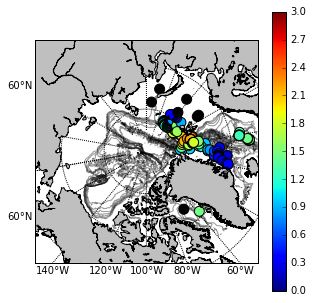

In [42]:
fig,ax=plt.subplots(1,1,facecolor='w',figsize=(5,5))

# create grids to interpolate (in meters, assume numpy as np)
res=40; xylim = [1e7, 1.7e7]
res=40; xylim = [1.3e6, 5.7e6]
#res=40; xylim = [0, 1e7]
listx_trans = np.linspace(xylim[0], xylim[1], res)
listy_trans = np.linspace(xylim[0], xylim[1], res)
gridx_trans, gridy_trans = np.meshgrid(listx_trans, listy_trans)

# Build Kriging model
from pykrige.ok import OrdinaryKriging
K_obj = OrdinaryKriging(Lon_279, Lat_279, var_279.temp.tolist(),
variogram_model='linear', verbose=False, enable_plotting=False)
## sample_var is the variable, same length as Lon_279
## variogram_model depends on your needs

# Execute the Kriging model
interpol_result, bias = K_obj.execute('grid', listx_trans, listy_trans)


m = Basemap(projection='npstere',boundinglat=64,lon_0=-100,resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0],zorder=-1)
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1],latmax=85,zorder=-1)


x_lon,y_lat = m(llon[9240:10801,:],llat[9240:10801,:])
mp.rcParams['contour.negative_linestyle'] = 'solid'
clevs = [-5000,-4500,-4000,-3500,-3000,-2500,-2000,-1500,-1000,-500]

#plt.plot(x_lon[::20,::20],y_lat[::20,::20],x_lon[::20,::20].T,y_lat[::20,::20].T,color='k',lw=0.1)
Lon_279,Lat_279 = m(var_279.Lon.tolist(),var_279.Lat.tolist())
#CS = ax.pcolormesh(Lon_279,Lat_279, data_new,zorder = -1, vmin=0, vmax=3)
m.fillcontinents(color = '0.75',alpha=1,zorder = 1)
m.contour(x_lon,y_lat,bathy_etopo[9240:10801,:],clevs,linewidth=0.075,colors='black',alpha=0.4,zorder=-1)
sc=ax.scatter(Lon_279,Lat_279,c=data_new,s=100,vmin=0,vmax=3)
CBar = plt.colorbar(CS) 


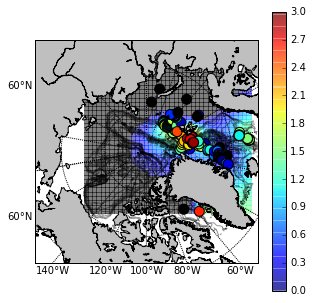

In [123]:
fig,ax=plt.subplots(1,1,facecolor='w',figsize=(5,5))

# create grids to interpolate (in meters, assume numpy as np)
res=40; xylim = [1e7, 1.7e7]
res=40; xylim = [1.3e6, 5.7e6]
#res=40; xylim = [0, 1e7]
listx_trans = np.linspace(xylim[0], xylim[1], res)
listy_trans = np.linspace(xylim[0], xylim[1], res)
gridx_trans, gridy_trans = np.meshgrid(listx_trans, listy_trans)

# Build Kriging model
from pykrige.ok import OrdinaryKriging
K_obj = OrdinaryKriging(Lon_279, Lat_279, var_279.temp.tolist(),
variogram_model='linear', verbose=False, enable_plotting=False)
## sample_var is the variable, same length as Lon_279
## variogram_model depends on your needs

# Execute the Kriging model
interpol_result, bias = K_obj.execute('grid', listx_trans, listy_trans)


m = Basemap(projection='npstere',boundinglat=64,lon_0=-100,resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0],zorder=-1)
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1],latmax=85,zorder=-1)


x_lon,y_lat = m(llon[9240:10801,:],llat[9240:10801,:])
mp.rcParams['contour.negative_linestyle'] = 'solid'
clevs = [-5000,-4500,-4000,-3500,-3000,-2500,-2000,-1500,-1000,-500]

#plt.plot(x_lon[::20,::20],y_lat[::20,::20],x_lon[::20,::20].T,y_lat[::20,::20].T,color='k',lw=0.1)
Lon_279,Lat_279 = m(var_279.Lon.tolist(),var_279.Lat.tolist())
CS = ax.pcolor(gridx_trans, gridy_trans, interpol_result,alpha=0.5,zorder = -1, vmin=0, vmax=3)
m.fillcontinents(color = '0.75',alpha=1,zorder = 1)
m.contour(x_lon,y_lat,bathy_etopo[9240:10801,:],clevs,linewidth=0.075,colors='black',alpha=0.4,zorder=-1)
sc=ax.scatter(Lon_279,Lat_279,c=var_279.temp.tolist(),s=100,vmin=0,vmax=3)
CBar = plt.colorbar(CS) 


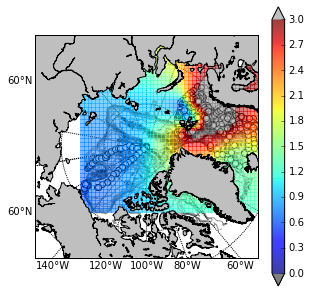

In [12]:
fig,ax=plt.subplots(1,1,facecolor='w',figsize=(5,5))

Lon_279,Lat_279 = m(var_279.Lon.tolist(),var_279.Lat.tolist())

# create grids to interpolate (in meters, assume numpy as np)
#res=40; xylim = [1e7, 1.7e7]
#res=40; xylim = [1.3e6, 5.7e6]
xymin = min(min(Lon_279),min(Lat_279))
xymax = max(max(Lon_279),max(Lat_279))

magnitude_min = int(math.log10(xymin))
round_down = int(xymin/float(pow(10,magnitude_min-1)))
xyminlim = round_down*pow(10,magnitude_min-1)

magnitude_max = int(math.log10(xymax))
round_up = np.ceil(xymax/int(pow(10,magnitude_max-1)))
xymaxlim = round_up*pow(10,magnitude_max-1)

res=(xymaxlim - xyminlim) /1e5; xylim = [xyminlim, xymaxlim]
listx_trans = np.linspace(xylim[0], xylim[1], res)
listy_trans = np.linspace(xylim[0], xylim[1], res)
gridx_trans, gridy_trans = np.meshgrid(listx_trans, listy_trans)

# Build Kriging model
from pykrige.ok import OrdinaryKriging
K_obj = OrdinaryKriging(Lon_279, Lat_279, var_279.temp.tolist(),
variogram_model='linear', verbose=False, enable_plotting=False)
## sample_var is the variable, same length as Lon_279
## variogram_model depends on your needs

# Execute the Kriging model
interpol_result, bias = K_obj.execute('grid', listx_trans, listy_trans)


m = Basemap(projection='npstere',boundinglat=64,lon_0=-100,resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0],zorder=-1)
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1],latmax=85,zorder=-1)


x_lon,y_lat = m(llon[9240:10801,:],llat[9240:10801,:])
mp.rcParams['contour.negative_linestyle'] = 'solid'
clevs = [-5000,-4500,-4000,-3500,-3000,-2500,-2000,-1500,-1000,-500]

#plt.plot(x_lon[::20,::20],y_lat[::20,::20],x_lon[::20,::20].T,y_lat[::20,::20].T,color='k',lw=0.1)
sc=ax.scatter(Lon_279,Lat_279,c='w',marker='o',edgecolors='k',s=35,vmin=0,vmax=3)
CS = ax.pcolor(gridx_trans, gridy_trans, interpol_result,zorder = 1,alpha=0.5,vmin=0, vmax=3)
m.fillcontinents(color = '0.75',alpha=1,zorder = 1)
m.contour(x_lon,y_lat,bathy_etopo[9240:10801,:],clevs,linewidth=0.075,colors='black',alpha=0.4,zorder=-1)
CBar = plt.colorbar(CS,extend='both') 
CBar.cmap.set_under('black')
CBar.cmap.set_over('grey')


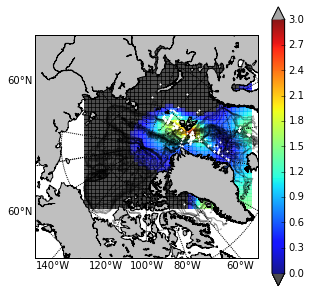

In [139]:
fig,ax=plt.subplots(1,1,facecolor='w',figsize=(5,5))

# create grids to interpolate (in meters, assume numpy as np)
#res=40; xylim = [1e7, 1.7e7]
#res=40; xylim = [1.3e6, 5.7e6]
xymin = min(min(Lon_279),min(Lat_279))
xymax = max(max(Lon_279),max(Lat_279))

magnitude_min = int(math.log10(xymin))
round_down = int(xymin/float(pow(10,magnitude_min-1)))
xyminlim = round_down*pow(10,magnitude_min-1)

magnitude_max = int(math.log10(xymax))
round_up = np.ceil(xymax/int(pow(10,magnitude_max-1)))
xymaxlim = round_up*pow(10,magnitude_max-1)

res=(xymaxlim - xyminlim) /1e5; xylim = [xyminlim, xymaxlim]
listx_trans = np.linspace(xylim[0], xylim[1], res)
listy_trans = np.linspace(xylim[0], xylim[1], res)
gridx_trans, gridy_trans = np.meshgrid(listx_trans, listy_trans)

# Build Kriging model
from pykrige.ok import OrdinaryKriging
K_obj = OrdinaryKriging(Lon_279, Lat_279, var_279.temp.tolist(),
variogram_model='linear', verbose=False, enable_plotting=False)
## sample_var is the variable, same length as Lon_279
## variogram_model depends on your needs

# Execute the Kriging model
interpol_result, bias = K_obj.execute('grid', listx_trans, listy_trans)


m = Basemap(projection='npstere',boundinglat=64,lon_0=-100,resolution='l')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0],zorder=-1)
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1],latmax=85,zorder=-1)


x_lon,y_lat = m(llon[9240:10801,:],llat[9240:10801,:])
mp.rcParams['contour.negative_linestyle'] = 'solid'
clevs = [-5000,-4500,-4000,-3500,-3000,-2500,-2000,-1500,-1000,-500]

#plt.plot(x_lon[::20,::20],y_lat[::20,::20],x_lon[::20,::20].T,y_lat[::20,::20].T,color='k',lw=0.1)
Lon_279,Lat_279 = m(var_279.Lon.tolist(),var_279.Lat.tolist())
CS = ax.pcolor(gridx_trans, gridy_trans, interpol_result,zorder = -1,alpha=0.7,vmin=0, vmax=3)
m.fillcontinents(color = '0.75',alpha=1,zorder = 1)
m.contour(x_lon,y_lat,bathy_etopo[9240:10801,:],clevs,linewidth=0.075,colors='black',alpha=0.4,zorder=-1)
sc=ax.scatter(Lon_279,Lat_279, facecolors='w',marker='+',edgecolors='none',s=5,vmin=0,vmax=3)
CBar = plt.colorbar(CS,extend='both') 
CBar.cmap.set_under('black')
CBar.cmap.set_over('grey')


In [9]:
interpol_result[None,None]
#test = np.isnan(bathy_etopo[9240:10801,:])

res,xylim
#LatLonPair
#int(64500/10000)
#math.ceil(64500/10000.0)

(88000.0, [1300000, 5700000.0])

In [151]:
xymin = 6859521
xymin = 6358746
magnitude_min = int(math.log10(xymin))
round_down = int(xymin/float(pow(10,magnitude_min-1)))
xyminlim = round_down*pow(10,magnitude_min-1)
xyminlim

6300000

In [149]:
xymax = 8126542
magnitude_max = int(math.log10(xymax))
round_up = np.ceil(xymax/int(pow(10,magnitude_max-1)))
xymaxlim = round_up*pow(10,magnitude_max-1)
xymaxlim


8200000.0

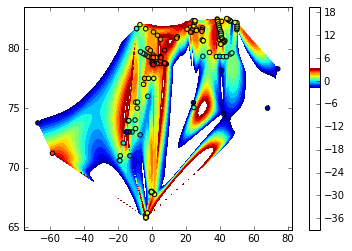

In [116]:
from scipy.interpolate import griddata

#Creating some data, with each coordinate and the values stored in separated lists
x = var_279.Lon.tolist()
y = var_279.Lat.tolist()
#z = np.meshgrid(x,y,var_279.temp.tolist())
z = var_279.temp.tolist()

# define grid.
xi, yi = np.mgrid[min(x):max(x):500j, min(y):max(y):500j]

# grid the data.
#zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
zi_linear = griddata((x, y), z, (xi, yi), method='linear')
zi = griddata((x, y), z, (xi, yi), method='cubic')
#zi = zi[np.where(np.isnan(zi) == False)]
zmin    = zi_linear[np.where(np.isnan(zi_linear) == False)].min()
zmax    = zi_linear[np.where(np.isnan(zi_linear) == False)].max()

# contour the gridded data, plotting dots at the randomly spaced data points.
#CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')#,vmin=0,vmax=3)
CS = plt.contourf(xi,yi,zi,200,vmin=zmin,vmax=zmax)
CBar = plt.colorbar() # draw colorbar
CBar.cmap.set_under(alpha=0.0)
CBar.cmap.set_over(alpha=0.0)

# plot data points.
#plt.scatter(x,y,marker='o',c='b',s=5)
plt.scatter(x,y,marker='o',c=z,s=20)

#plt.title('griddata test (%d points)' % npts)
plt.show()




In [93]:
len(x),len(y),len(z)
xi.shape,yi.shape,zi.shape,zi
#t=zi[np.where(np.isnan(zi) == False)]
#t

((500, 500),
 (500, 500),
 (149023,),
 array([-1.46486899, -1.51162122, -1.55837672, ..., -1.51349745,
        -1.48798567, -1.46276072]))